In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
import re
import wordninja

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install unidecode
!{sys.executable} -m pip install wordninja

In [2]:
# Set the file path
file = "/Users/aimanfikri/Desktop/Work/EDOTCO/AssessmentV2/fake_job_postings.csv"

## Initial Dataset Validation

Before undertaking the analysis, we can first examine the general nature of the dataset to get a better 'sense' of the data. Key focus questions include

- What does the dataset look like?
- What are factors that can influence the analysis of the data set?
- Are there glaring biases in the data that could impact analysis?

In [3]:
# Load the data
df = pd.read_csv(file)

# See what the data looks like
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


From the above output, we can get a general look at how the dataset is populated:
- Some columns appear to always contain values, whereas other columns (e.g., salary_range) appear to have nulls more frequently
- A degree of label encoding has already been done for columns such as telecommuting, has_company_logo and so on
- The fraudulent nature of a job posting is indicated by a binary label 1 or 0 in the 'fraudulent' column.

In [4]:
# Examine data types, number of nulls and size of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

From the above we can see that there are a total of 17880 entries.
- Aside from the encoded columns, the 'title' column is the only one where all the rows are populated
- Some columns are mostly populated, these include location and description.
- Many columns have multiple null values, with the salary_range column having the most null values.
- Multiple columns have already been encoded, as indicated by the type being and integer. This includes columns such as telecommuting, has_company_logo, has_questions and fradulent

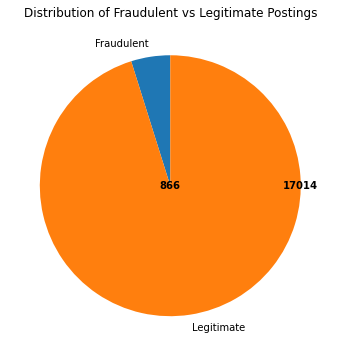

In [5]:
# Count the number of fraudulent and legitimate postings
fraudulent_count = df['fraudulent'].sum()
legitimate_count = len(df) - fraudulent_count

# Create labels and values for the pie chart
labels = ['Fraudulent', 'Legitimate']
values = [fraudulent_count, legitimate_count]

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, startangle=90)

# Add count values as labels
for i, value in enumerate(values):
    plt.text(i, 0, str(value), ha='center', va='center', fontweight='bold')

plt.title('Distribution of Fraudulent vs Legitimate Postings')
plt.show()

We see that distribution is heavily skewed towards legitimate postings. This imbalance should be considered when constructing the machine learning model and during the initial exploratory analysis.

## Exploratory Data Analysis (EDA)

Now that we have a high-level idea of the dataset we're working with, here are some potential questions that we can explore:

- What is the distribution of nulls in the dataset? Are there differences between legitimate and fradulent postings?
- Are there more null columns in a particular posting for fradulent postings? I.e., if 5/15 of columns are null, is that an indicator of a fradulent posting?
- What are the distributions of total number of words? Are there differences between legitimate and fradulent postings?
- Are there certain word choices that are more common in fradulent postings?
- We also have a mixture of categorical and discrete variables. Is there a way for us to encode these features so that they are all a singular data type?

## Distribution of Nulls

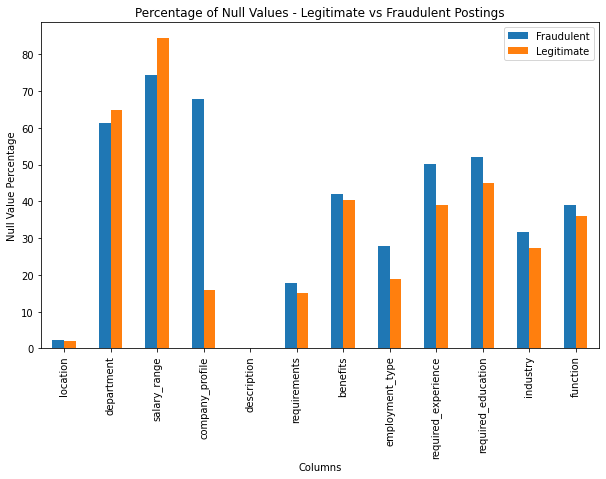

In [6]:
## Distribution of nulls by column between legitimate and fradulent postings

# Create dictionary for dataframe
null_percentages_dict = {
    'Column': [],
    'Fraudulent': [],
    'Legitimate': []
}

# Filter the columns of interest
columns_of_interest = ['location', 'department', 'salary_range', 'company_profile',
                       'description', 'requirements', 'benefits', 'employment_type',
                       'required_experience', 'required_education', 'industry', 'function']

# Iterate over the columns of interest
# Normalise over total number of postings
for column in columns_of_interest:
    total_fraudulent_postings = df['fraudulent'].sum()
    total_legitimate_postings = df.shape[0] - total_fraudulent_postings

    fraudulent_null_count = df[df['fraudulent'] == 1][column].isnull().sum()
    fraudulent_null_percentage = (fraudulent_null_count / total_fraudulent_postings) * 100

    legitimate_null_count = df[df['fraudulent'] == 0][column].isnull().sum()
    legitimate_null_percentage = (legitimate_null_count / total_legitimate_postings) * 100

    # Add the null value percentages to the dictionary
    null_percentages_dict['Column'].append(column)
    null_percentages_dict['Fraudulent'].append(fraudulent_null_percentage)
    null_percentages_dict['Legitimate'].append(legitimate_null_percentage)

# Create the dataframe
null_percentages_df = pd.DataFrame(null_percentages_dict)

# Plot the stacked bar chart
null_percentages_df.plot(x='Column', kind='bar', figsize=(10, 6))
plt.title('Percentage of Null Values - Legitimate vs Fraudulent Postings')
plt.xlabel('Columns')
plt.ylabel('Null Value Percentage')
plt.legend()
plt.show()

It appears that fradulent job postings have a higher percentage of nulls compared to legitimate postings for most columns, including 'requirements', 'benefits' and 'employment_type'. It is especially interesting to note that 60% of fradulent postings don't have a company_profile value, compared to less than 20% for legitimate postings. This suggest that the lack of a company profile is a big indicator, despite the skew in the dataset mentioned earlier.

For the most part, it appears that fradulent postings generally have more nulls than legitimate job postings. However, with the exxception of the 'company_profile' column, it is difficult to determine if this difference is not entirely due to the smaller sample size

Let's now look at total null count across the columns. Would fradulent job postings have more null values across columns?

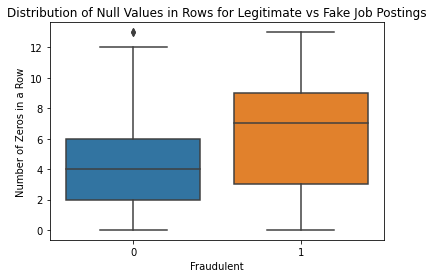

In [7]:
# Add 'Total Null Columns' column

# Replacing nulls with 0s to account for label encoded columns 
df_null_col = df.fillna(0)

# ignoring 'telecommuting', 'job_id' and 'fradulent' columns
df_null_col['num_zeros'] = df_null_col.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]].eq(0).sum(axis=1)

sns.boxplot(data=df_null_col, x='fraudulent', y='num_zeros')
plt.xlabel('Fraudulent')
plt.ylabel('Number of Zeros in a Row')
plt.title('Distribution of Null Values in Rows for Legitimate vs Fake Job Postings')


plt.show()

It seems that fraudulent postings seem to have more null values in a particular posting. There also doesn't seem to be any legitimate postings with more than 12 null values, except for some outliers. This appears to support the idea that fraudulent postings tend to have less information in general compared to legitimate postings.

## Distribution of Word Counts 
If we carry on with the similar train of thought, we might reason that if fraudulent job postings have less information that legitimate ones, perhaps the total number of words in text-heavy columns are lesser for fraudulent compared to legitimate postings.

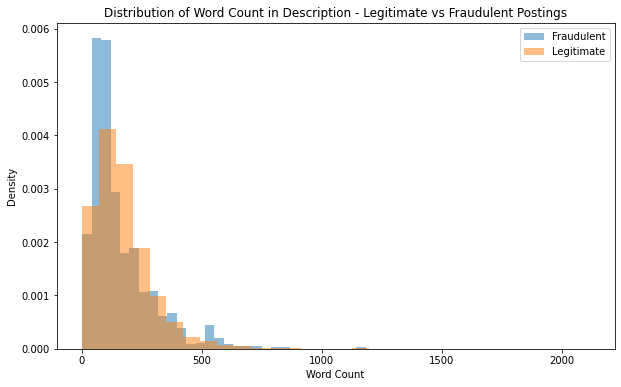

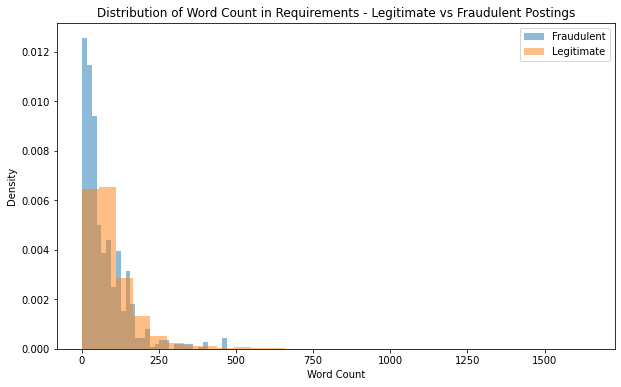

In [8]:
## Examining total word count for certain columns

# Replace null values with an empty string 
df_filled = df.fillna('')

# Add 'Total Words in Description' column
df_filled['Total Words in Description'] = df_filled['description'].str.split().apply(len)

# Add 'Total Words in Requirements' column
df_filled['Total Words in Requirements'] = df_filled['requirements'].str.split().apply(len)

# Filter the data for fraudulent and legitimate postings (Description)
fraudulent_word_counts = df_filled[df_filled['fraudulent'] == 1]['Total Words in Description']
legitimate_word_counts = df_filled[df_filled['fraudulent'] == 0]['Total Words in Description']

# Filter out values with length less than 1
fraudulent_word_counts = fraudulent_word_counts[fraudulent_word_counts >= 1]
legitimate_word_counts = legitimate_word_counts[legitimate_word_counts >= 1]

# Filter the data for fraudulent and legitimate postings (Requirements)
fraudulent_word_counts_rq = df_filled[df_filled['fraudulent'] == 1]['Total Words in Requirements']
legitimate_word_counts_rq = df_filled[df_filled['fraudulent'] == 0]['Total Words in Requirements']

# Filter out values with length less than 1
fraudulent_word_counts_rq = fraudulent_word_counts_rq[fraudulent_word_counts_rq >= 1]
legitimate_word_counts_rq = legitimate_word_counts_rq[legitimate_word_counts_rq >= 1]


# Plot a normalised distribution of word counts (description)
plt.figure(figsize=(10, 6))
plt.hist(fraudulent_word_counts, bins=30, alpha=0.5, density=True, label='Fraudulent')
plt.hist(legitimate_word_counts, bins=30, alpha=0.5, density=True, label='Legitimate')
plt.title('Distribution of Word Count in Description - Legitimate vs Fraudulent Postings')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot a normalised distribution of word counts (requirements)
plt.figure(figsize=(10, 6))
plt.hist(fraudulent_word_counts_rq, bins=30, alpha=0.5, density=True, label='Fraudulent')
plt.hist(legitimate_word_counts_rq, bins=30, alpha=0.5, density=True, label='Legitimate')
plt.title('Distribution of Word Count in Requirements - Legitimate vs Fraudulent Postings')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.show()

It appears that similar to the null distribution, fradulent job postings have less information as measured by 'word count' as shown by a greater skew towards lower word counts. However, just as from before, it is difficult to determine whether this difference is due to the smaller sample size of fraudulent postings.

## Natural Language Processing

Another interesting analysis to carry out on this dataset involves looking at the words being used in the job postings, and seeing if there are any patterns that exist between fraudulent and legitimate postings.
To do this, we could start with looking at the distribution of frequencies of certain words.
We can then assess whether the choice of words are a significant enough factor to include in our model. Let's take a look at just the top 10 words to see if there are any major differences. 

Zipf's law postulates that the frequency distribution of words is equal to 1/n of the highest frequency, with n being the rank of the word. Assuming this is the case, the frequencies of words will likely not differ much beyond the 10 highest ranking words.

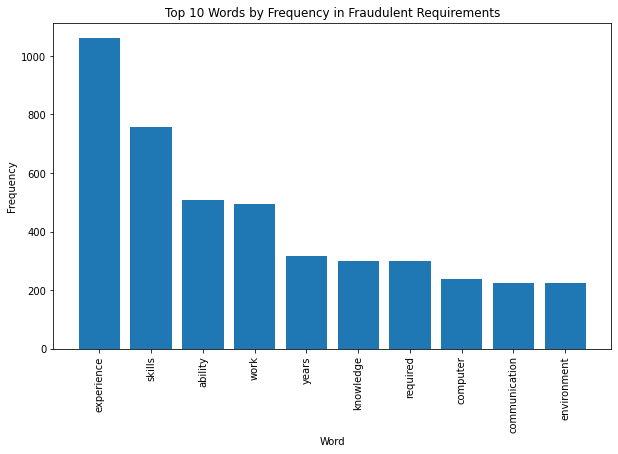

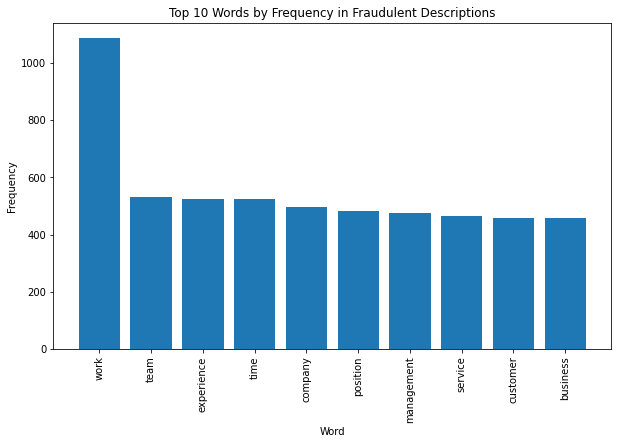

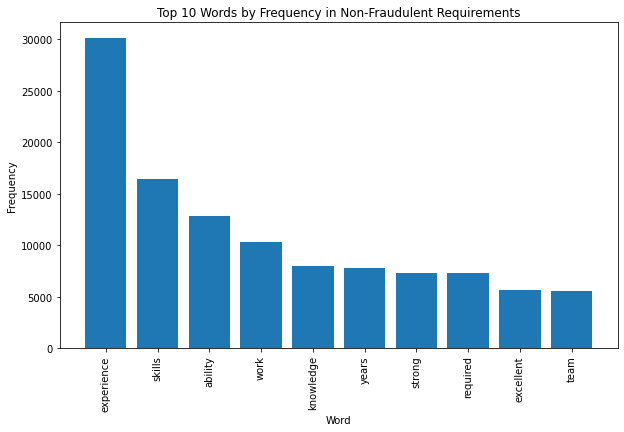

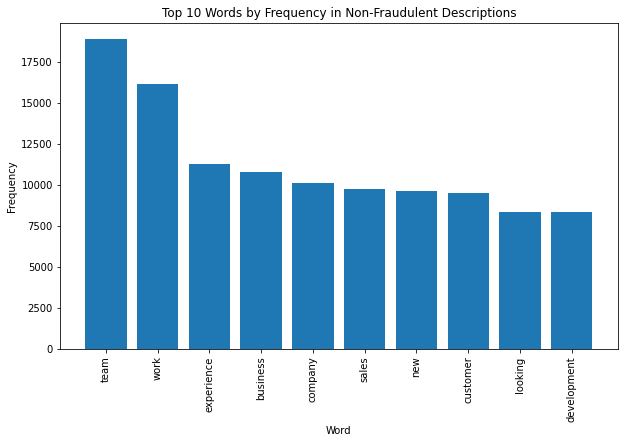

In [9]:
# Filter the DataFrame to separate fraudulent and non-fraudulent job postings
fraudulent_df = df[df['fraudulent'] == 1]
non_fraudulent_df = df[df['fraudulent'] == 0]

# Define additional stopwords
additional_stopwords = ['must','amp']

def get_word_frequencies(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english')).union(additional_stopwords)
    words = [word.lower() for word in words if word.lower() not in stop_words]
    
    # Word Segmentation
    segmented_words = []
    for word in words:
        segmented_words.extend(wordninja.split(word))
    
    # Filter out non-alphabetic words and words with less than 3 characters
    words = [word for word in segmented_words if word.isalpha() and len(word) >= 3]    
    
    # Count word frequencies
    word_counts = Counter(words)

    # Create a DataFrame with word frequencies and sort by frequency in descending order
    word_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    word_df = word_df.sort_values(by='frequency', ascending=False)
    
    return word_df

# Apply the function to the text columns in the fraudulent and non-fraudulent dataframes
fraudulent_req_word_df = get_word_frequencies(' '.join(fraudulent_df['requirements'].dropna()))
fraudulent_desc_word_df = get_word_frequencies(' '.join(fraudulent_df['description'].dropna()))
non_fraudulent_req_word_df = get_word_frequencies(' '.join(non_fraudulent_df['requirements'].dropna()))
non_fraudulent_desc_word_df = get_word_frequencies(' '.join(non_fraudulent_df['description'].dropna()))

def plot_top_words_bar_chart(word_df, column_name, title, n=10):
    # Sort the word_df by frequency in descending order and select the top N words
    top_words = word_df.sort_values(by='frequency', ascending=False).head(n)

    # Plot bar chart for top N words by frequency
    plt.figure(figsize=(10, 6))
    plt.bar(top_words['word'], top_words['frequency'])
    plt.title(title)
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

plot_top_words_bar_chart(fraudulent_req_word_df,'word','Top 10 Words by Frequency in Fraudulent Requirements',n=10)
plot_top_words_bar_chart(fraudulent_desc_word_df,'word','Top 10 Words by Frequency in Fraudulent Descriptions',n=10)
plot_top_words_bar_chart(non_fraudulent_req_word_df,'word','Top 10 Words by Frequency in Non-Fraudulent Requirements',n=10)
plot_top_words_bar_chart(non_fraudulent_desc_word_df,'word','Top 10 Words by Frequency in Non-Fraudulent Descriptions',n=10)


From the above, we can see the that the top occurring words are roughly similar between fraudulent and non-fraudulent postings. This means that in terms of frequency, it is unlikely that this feature would be significantly helpful in our prediction. In fact, it could prove to have the opposite effect, as the dataset is already imbalanced towards non-Fraudulent postings. Incorporating the word choice feature might influence the prevalence of false negatives in our predictions.

We could also do a check to see if there are some 'hot' words that are used in fraudulent postings that are not seen in non-fraudulent postings. To do this, we can look at unique words between the two classes and see if there are any that stand out.

In [10]:
def find_unique_words(fraudulent_word_df, non_fraudulent_word_df):
    
    # Filter out non-alphabetic words and words with less than 3 characters
    fraudulent_word_df = fraudulent_word_df[(fraudulent_word_df['word'].str.isalpha()) & (fraudulent_word_df['word'].str.len() >= 3)]
    non_fraudulent_word_df = non_fraudulent_word_df[(non_fraudulent_word_df['word'].str.isalpha()) & (non_fraudulent_word_df['word'].str.len() >= 3)]
 
    # Get the unique words in fraudulent postings
    fraudulent_words = set(fraudulent_word_df['word'])
    
    # Get the unique words in non-fraudulent postings
    non_fraudulent_words = set(non_fraudulent_word_df['word'])
    
    # Find the words that occur in fraudulent postings but not in non-fraudulent ones
    unique_words = fraudulent_words - non_fraudulent_words
    
    return unique_words

# Find unique words in fraudulent requirements compared to non-fraudulent requirements
fraudulent_req_unique_words = find_unique_words(fraudulent_req_word_df, non_fraudulent_req_word_df)

# Find unique words in fraudulent description compared to non-fraudulent description
fraudulent_desc_unique_words = find_unique_words(fraudulent_desc_word_df, non_fraudulent_desc_word_df)

# Print the unique words in fraudulent requirements
print("Unique words in fraudulent requirements:")
print(fraudulent_req_unique_words)
print()

# Print the unique words in fraudulent description
print("Unique words in fraudulent description:")
print(fraudulent_desc_unique_words)
print()

Unique words in fraudulent requirements:
{'bakersfield', 'servo', 'thermoplastic', 'uniformity', 'toxins', 'velit', 'sistance', 'geologist', 'explosive', 'adipisci', 'scour', 'loose', 'mauris', 'spill', 'piston', 'refunds', 'wannabe', 'integer', 'nomenclature', 'formulates', 'stairways', 'nulla', 'sapphire', 'deviate', 'obsolete', 'staircases', 'scalping', 'posuere', 'aker', 'mollis', 'webcam', 'proposes', 'ionis', 'vall', 'kern', 'hatch', 'tellus', 'uta', 'topside', 'hostess', 'accords', 'lubricants', 'hospitalizations', 'headless', 'escalates', 'denomination', 'bravo', 'funneling', 'necessities', 'ultricies', 'irregularly', 'arranges', 'attains', 'nib', 'newfoundland', 'denton', 'maecenas', 'etch', 'drainage', 'tracers', 'gearboxes', 'technicalities', 'shipyard', 'emit', 'venturi', 'massa', 'tempus', 'xmas', 'dun', 'premiums', 'topsides', 'quam', 'conclude', 'carb', 'abbreviations', 'dales', 'inhalation', 'eet', 'pcc', 'intercontinental', 'bleach', 'warder', 'trademarks', 'enim', 'as

This is interesting. There are some words that we don't typically associate with job postings, such as the word 'husbands' or 'daughters'. There are also some other negative words like 'fatigue', 'dismissal' and 'dislike' that is oftentimes rare in legitimate job postings, as it is not unreasonable to assume that job posters would likely want to portray more positive outlooks in their postings.

Let's try to explore some of these postings that contain these unique 'negative sounding' words.

In [11]:
# Selected word set
word_set = {'angry', 'husband', 'daughter','fatigue','dismissal','dislike','stubborn','wannabe','disappoint'}

df['requirements'] = df['requirements'].replace(np.nan, '', regex=True)

filtered_df_unique_words = df[df['requirements'].apply(lambda x: any(word.lower() in x.lower() for word in word_set))]
filtered_df_unique_words.info()
filtered_df_unique_words.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 1822 to 17808
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               11 non-null     int64 
 1   title                11 non-null     object
 2   location             11 non-null     object
 3   department           5 non-null      object
 4   salary_range         3 non-null      object
 5   company_profile      4 non-null      object
 6   description          11 non-null     object
 7   requirements         11 non-null     object
 8   benefits             9 non-null      object
 9   telecommuting        11 non-null     int64 
 10  has_company_logo     11 non-null     int64 
 11  has_questions        11 non-null     int64 
 12  employment_type      5 non-null      object
 13  required_experience  4 non-null      object
 14  required_education   5 non-null      object
 15  industry             6 non-null      object
 16  func

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
1822,1823,Structural Engineer,"US, TX, Houston",NaN,NaN,Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes• Tech...,We offer • Friendly colleagues in an industry ...,0,1,0,Full-time,NaN,Bachelor's Degree,Oil & Energy,Engineering,1
2070,2071,Confidently Humble Javascript Front-end Developer,"US, ,",NaN,NaN,NaN,Confidently Humble?We love working with people...,You’re the one we’re looking for if you:Are a ...,How we work:We all work from home. We don’t tr...,1,0,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0
2921,2922,Church Administrator/ Secretary,"US, OH, Cincinnati",NaN,NaN,NaN,Description of the Church Administrative Assis...,Qualifications of the Church Administrative As...,Competitive weekly pay and full benefits after...,0,1,0,NaN,NaN,NaN,NaN,NaN,1
3326,3327,Customer Assistant,"CA, AB,",NaN,NaN,NaN,Job Description: We are looking for customer a...,Skills/Qualifications:- Post-secondary educati...,NaN,1,0,0,NaN,NaN,NaN,NaN,NaN,1
3627,3628,Church Administrator/ Secretary,"US, OH, Cincinnati",NaN,NaN,Bradley Contracting Group Corporation offers a...,Description of the Church Administrative Assis...,Qualifications of the Church Administrative As...,Weekly competitive pay and Fulltime benefits a...,0,1,0,NaN,NaN,NaN,NaN,NaN,1
4349,4350,Structural Engineer,"US, TX, Houston",Engineering,NaN,NaN,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes• Tech...,We offer • Friendly colleagues in an industry ...,0,0,0,NaN,NaN,NaN,Oil & Energy,Engineering,1
4607,4608,CALL CENTER REP,"US, TX, DALLAS",CALLCENTER,30000-45000,The Accion story began more than 100 years ag...,Our Call Center Rep would be expected to be ex...,The qualifications for this position ensure yo...,"100% coverage of dental, vision and life insur...",0,1,1,Full-time,Associate,High School or equivalent,Financial Services,Customer Service,1
6528,6529,CALL CENTER REP,"US, TX, AUSTIN",CALLCENTER,30000-40000,The Accion story began more than 100 years ag...,Our Call Center Rep would be expected to be ex...,Requirements:The qualifications for this posi...,"100% coverage of dental, vision and life insur...",0,1,1,Full-time,Associate,High School or equivalent,Financial Services,Customer Service,1
7370,7371,Front-End Developer,"US, IN, Bloomington",Product Development,NaN,NaN,RideAmigos needs a great Front-End Developer t...,This opening is for a qualified developer focu...,"This is a full time, salaried position. Let us...",0,1,1,NaN,NaN,NaN,NaN,NaN,1
17653,17654,Senior JavaScript Developer,"US, IN, Bloomington",Product Development,NaN,NaN,RideAmigos is hiring a senior level JavaScript...,This position is for a senior developer focuse...,"This is a full time, salaried position. Let us...",0,1,1,NaN,NaN,NaN,NaN,NaN,1


Looks like we have about 11 entries that contain the 'negative sounding' words we explored earlier. This is too little to draw any meaningful conclusions about given our dataset. However, it is a worthwhile element to explore should we wish to improve our model further. We could possibly look at the overall sentiment of a posting e.g., how urgent the posting is, how 'negative' the words being used are and so on.

We could also see some of the job postings being very similar, for example job_id 4608 and 6529. We see this similarity for job_id 2922 and 3628 as well. This might be a worthy point to note, as fake job postings would likely try to maximize their chances of getting a candidate by attempting to increase their visibility. Therefore, fake job postings might be very similar to each other, with only minor differences.

## Machine Learning Approach

Now that we have sufficiently explored the data, we are ready to determine  our machine learning approach.

We recognise that this is a classification problem. Therefore, a Naive Bayes model would be a good starting point. We can then determine if more advanced models like Random Forest would lead to a significant improvement in performance. In either case, the predicted outputs of the model should be a value of 0 (non-fraudulent) or 1 (fraudulent). 

We also noted earlier that our dataset suffers from a relative imbalance between the majority class (non-fraudulent) and minority class (fraudulent). We could attempt to rebalance the data by upsampling the minority class by generating similar instances of fraudulent data points, or by downsampling the majority class by randomly selecting a subset. We could  try constructing a model without rebalancing first, then see if rebalancing the dataset could help with performance.

A key issue is the mixture of categorical and discrete data types. Based on our EDA, it appears that a simple starting point would be to treat these columns as binary 'null' or 'non-null' values. Other columns with a smaller set of unique values like 'required_experience' and 'required_education' could be label encoded, as these wouldn't affect our column numbers too much. However, for simplicity in our model construction, we would treat these columns the same way.

In terms of performance metrics, given that this is a classification task, the F1 score, which accounts for precision and recall of the model predictions would be most indicative of the model's performance. We might be more interested in recall compared to precision, as in our use case it is perhaps better to identify as many fraudulent postings as possible. This is because false positives can still be valuable information to aid the job poster in making their postings better. 

In conclusion, our approach could look something like the following:
- <b>Data Preparation</b> : Encode relevant columns into 1s(non-null) and 0s(null). Add our 'Word Count' features for the description and requirement columns.
- <b>Model Training and Selection</b> : Evaluate the performance of various models based on the F1 score.
- <b>Model Tuning</b> : Evaluate methods to improve the performance of the chosen model

## Data Preparation

In [12]:
# Load the data
df = pd.read_csv(file)

# This is our original dataframe
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [13]:
columns_to_encode = ['location', 'department', 'salary_range', 'company_profile', 
                   'description', 'requirements', 'benefits','employment_type','required_experience',
                   'required_education', 'industry', 'function']

# encode columns into 1s (contains value) and 0s (null)
for column in columns_to_encode:
    df['has_' + column] = df[column].notnull().astype(int)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_salary_range,has_company_profile,has_description,has_requirements,has_benefits,has_employment_type,has_required_experience,has_required_education,has_industry,has_function
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,0,1,1,1,0,1,1,0,0,1
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,1,1,1,1,1,1,0,1,1
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,0,1,1,1,0,0,0,0,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,1,1,1,1,1,1,1,1,1
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,0,1,1,1,1,1,1,1,1,1


In [14]:
## Including total word count for columns 'description' and 'requirements'
# Replace null values with an empty string 
df_word_count = df.fillna('')

# Add 'Total Words in Description' column
df_word_count['Total Words in Description'] = df_filled['description'].str.split().apply(len)

# Add 'Total Words in Requirements' column
df_word_count['Total Words in Requirements'] = df_filled['requirements'].str.split().apply(len)

# Add new features to dataframe
df['description_word_count'] = df_word_count['Total Words in Description']
df['requirements_word_count'] = df_word_count['Total Words in Requirements']

# Drop columns
columns_to_drop = ['job_id','title', 'location', 'department', 'salary_range', 'company_profile', 
                   'description', 'requirements', 'benefits','employment_type','required_experience',
                   'required_education', 'industry', 'function']
df = df.drop(columns=columns_to_drop)

# Dataframe for model training
df = df.fillna('')
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,has_location,has_department,has_salary_range,has_company_profile,has_description,has_requirements,has_benefits,has_employment_type,has_required_experience,has_required_education,has_industry,has_function,description_word_count,requirements_word_count
0,0,1,0,0,1,1,0,1,1,1,0,1,1,0,0,1,124,115
1,0,1,0,0,1,1,0,1,1,1,1,1,1,0,1,1,315,200
2,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,50,164
3,0,1,0,0,1,1,0,1,1,1,1,1,1,1,1,1,346,176
4,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,168,89


Now that our data is ready, we can begin constructing our machine learning model.

## Model Training and Selection 

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

In [16]:
# Define the target variable
y = df['fraudulent']

# Define the predictor variables
X = df.copy()
X = X.drop('fraudulent',axis=1)

# Extract the word count columns
word_count_columns = ['description_word_count', 'requirements_word_count']
X_word_count = X[word_count_columns]

# As our values are predominantly 1s and 0s, we would need to scale our word count columns
# This is so that they don't heavily influence the model during the training process

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the word count columns
X_word_count_scaled = scaler.fit_transform(X_word_count)

# Update the scaled word count columns in the original dataframe
X[word_count_columns] = X_word_count_scaled

X.head()

,telecommuting,has_company_logo,has_questions,has_location,has_department,has_salary_range,has_company_profile,has_description,has_requirements,has_benefits,has_employment_type,has_required_experience,has_required_education,has_industry,has_function,description_word_count,requirements_word_count
0,0,1,0,1,1,0,1,1,1,0,1,1,0,0,1,-0.376688,0.452746
1,0,1,0,1,1,0,1,1,1,1,1,1,0,1,1,1.172369,1.493767
2,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,-0.976847,1.052864
3,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1.423787,1.199832
4,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,-0.019837,0.134316


In [17]:
# Specify the train and test sets
# Stratify to maintain relative imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Initialize the Naive Bayes models
Cnb = ComplementNB()
Gnb = GaussianNB()
Bnb = BernoulliNB()

def evaluate_model(nb):
    # Train the model
    nb.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print the performance metrics
    print('----', str(nb), '----')
    print('Accuracy:', '%.3f' % accuracy)
    print('Precision:', '%.3f' % precision)
    print('Recall:', '%.3f' % recall)
    print('F1 Score:', '%.3f' % f1)
    print('      ')

evaluate_model(Bnb)
evaluate_model(Gnb)

# redefining X for Cnb; remove negative values
X_Cnb = X.drop('description_word_count', axis=1)
X_Cnb = X_Cnb.drop('requirements_word_count', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_Cnb, y, test_size=0.25, stratify=y, random_state=42)
evaluate_model(Cnb)


---- BernoulliNB() ----
Accuracy: 0.921
Precision: 0.290
Recall: 0.435
F1 Score: 0.348
      
---- GaussianNB() ----
Accuracy: 0.950
Precision: 0.318
Recall: 0.032
F1 Score: 0.059
      
---- ComplementNB() ----
Accuracy: 0.820
Precision: 0.161
Recall: 0.648
F1 Score: 0.258
      


The Bernoulli Naive Bayes clearly outperforms the other two implementations. We're getting somewhere, but the performance isn't great. Let's try out a different model.

In [18]:
# Defining train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


# Initialize random forest 
def evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print the performance metrics
    print('Accuracy:', '%.3f' % accuracy)
    print('Precision:', '%.3f' % precision)
    print('Recall:', '%.3f' % recall)
    print('F1 Score:', '%.3f' % f1)
    
evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None)


Accuracy: 0.970
Precision: 0.800
Recall: 0.519
F1 Score: 0.629


Looks like our F1 score is significantly better. Let's see if see can improve the model further by tuning the hyperparameters. At this stage, we can also take steps to see if we can account for the imbalance in our dataset favouring the majority class.

## Hyperparameter Tuning

In [20]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500], 
    'max_depth': [None, 5, 10, 20, 30, 40, 50],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 10, 20, 50]]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=1),  # Set zero_division parameter to 1
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Create the GridSearchCV instance
grid_search = GridSearchCV(rf, param_grid, scoring=scoring, refit='f1', cv=5)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best hyperparameters and best score
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 50, 'n_estimators': 100}


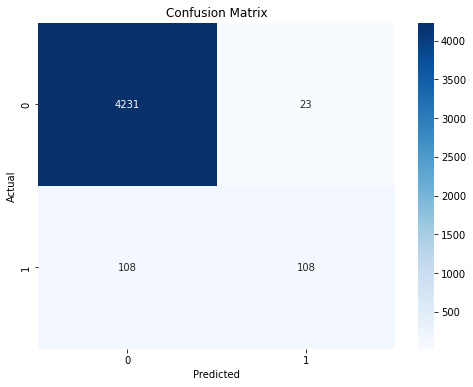

Accuracy: 0.971
Precision: 0.824
Recall: 0.500
F1 Score: 0.622


In [32]:
# Defining train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


# Initialize random forest with tuned hyperparameters
def evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=50, class_weights = None):
    # Initialize the Random Forest classifier
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight=class_weights)

    # Train the model
    rf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print the performance metrics
    print('Accuracy:', '%.3f' % accuracy)
    print('Precision:', '%.3f' % precision)
    print('Recall:', '%.3f' % recall)
    print('F1 Score:', '%.3f' % f1)
    
    
evaluate_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=50, class_weights = {0: 1, 1: 5} )

Looks like the hyperparameter tuning had little to no effect on the performance of our model, suggesting that we have likely reached peak performance based on our features and machine learning approach. Our confusion matrix shows that for the most part, we identified the non-fraudulent job postings correctly. However, it is worth noting that this is likely due to the major imbalance in our data set.

As for actual fraudulent postings, it seems that we only successfully identified fraudulent postings half of the time. This is as indicated by our recall metric.

We mentioned earlier that the dataset is heavily imbalanced, with only roughly 5% being the minority class. Although we attempted to account for this imbalance using the class_weights parameter, there was little to no effect on the performance of the model. In fact, it seemed to have a minor detrimental effect as indicated by the better performance in the default model.